Figure 3 analysis
Performing ARU-E (Extractin part) showing that from robust FAT model we can obtain non-robust model

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
# Specify aggregation method, number of clients, and dataset
setting, num_user = "FedAvg_adv", 40
exp = "celeba"

# Load models for FAT and FedAvg - write down path to where weights are saved
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FAT/'
save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/celeba/250123_icml25/FedAvg/'
# save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
# save_path_FedAvg =  '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

# Attack parameters for performing PGD 
eps_attack = 4.0
eps_train = 4.5
step_size = 0.01
steps = 10

In [4]:
# Generate instance of aggregator that holds all clients, data and models and load relevant models in
try: # Skip loading if already loaded
    aggregator_og
except:
    aggregator_og, clients, args_ = set_args(setting, num_user,  experiment = exp) # Indicate dataset here

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator_og, args_)[0])
model_Fedavg = copy.deepcopy(import_model_weights(num_user, setting, save_path_FedAvg, aggregator_og, args_)[0])

# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = params_FAT.keys() # [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key] # 

==> Clients initialization..
===> Building data iterators..
get_celeba - Combining train batches... float16 version
get_celeba -Combining test batches... float16 version


 26%|██▌       | 39/150 [00:01<00:03, 35.51it/s]


===> Initializing clients..


  0%|          | 0/40 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 40/40 [00:09<00:00,  4.14it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [5]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 10
num_users = [1,3,5,10]

test_acc_gather = {}
adv_acc_gather = {}
test_acc_std_gather = {}
adv_acc_std_gather = {}

peturb_prop = 0.5
cutoff_round = 5


# save_path_FAT150 = '/home/ubuntu/fedatk_unl_tj/weights/cifar10/250123_icml25/FAT_R50/'

for num_user in num_users:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = exp)

    test_acc_gather[num_user] = []
    adv_acc_gather[num_user] = []
    test_acc_std_gather[num_user] = []
    adv_acc_std_gather[num_user] = []
    
    # Test performance of aggregator on data 
    aggregator.load_state(dir_path=save_path_FAT)
    aggregator.update_clients()
    
    # Trim number of clients
    aggregator.clients = aggregator.clients[0:num_user]
    aggregator.clients_weights = np.divide(aggregator.clients_weights[0:num_user],np.sum(aggregator.clients_weights[0:num_user].numpy()))
    aggregator.n_clients_per_round = num_user
    
    model_FAT = pull_model_from_agg(aggregator)
    model_FAT.eval()

    
    # Add standard deviation
    acc, adv_acc = get_adv_acc(aggregator_og, model_FAT)

    print("round", 0 ,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
    test_acc_gather[num_user] += [np.mean(acc)]
    adv_acc_gather[num_user] += [np.mean(adv_acc)]
    test_acc_std_gather[num_user] += [np.std(acc)]
    adv_acc_std_gather[num_user] += [np.std(adv_acc)]
    
    # Setting evasion attack parameters
    x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
    x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
    atk_params = PGD_Params()
    atk_params.set_params(batch_size=1, iteration = 5,
                    target = -1, x_val_min = x_min, x_val_max = x_max,
                    step_size = 0.05, step_norm = "inf", eps = 4.5, eps_norm = 2)
    
    #  Assign proportion and attack params
    if True:
        for c in aggregator.clients:
            c.unlearning_flag = True
            
    for i in range(len(aggregator.clients)):
        aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
        aggregator.clients[i].update_advnn()
        aggregator.clients[i].assign_advdataset()
    
    for round in range(1,num_rounds+1):
        
        aggregator.mix()
        model_overfit = pull_model_from_agg(aggregator)
        
        if round%1 == 0:
            
            if round <= cutoff_round:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].set_adv_params(peturb_prop, atk_params)
                    aggregator.clients[i].update_advnn()
                    aggregator.clients[i].assign_advdataset()
            else:
                for i in range(len(aggregator.clients)):
                    aggregator.clients[i].reset_dataset()
                

            model_overfit.eval()
            acc, adv_acc = get_adv_acc(aggregator_og, model_overfit)

            print("round", round,"Test acc: ", np.mean(acc), "(", np.std(acc),")", "adv acc: ", 
                  np.mean(adv_acc), "(", np.std(adv_acc),")")
            test_acc_gather[num_user] += [np.mean(acc)]
            adv_acc_gather[num_user] += [np.mean(adv_acc)]
            test_acc_std_gather[num_user] += [np.std(acc)]
            adv_acc_std_gather[num_user] += [np.std(adv_acc)]

    del aggregator, clients, args_
    gc.collect()
    torch.cuda.empty_cache()


==> Clients initialization..
===> Building data iterators..
get_celeba - Combining train batches... float16 version
get_celeba -Combining test batches... float16 version


  0%|          | 0/150 [00:00<?, ?it/s]


===> Initializing clients..


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


round 0 Test acc:  0.815994119644165 ( 0.06613109358428626 ) adv acc:  0.5120000027120113 ( 0.10585051442048657 )


/home/ubuntu/fedatk_unl_tj/learners/learner.py:192: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


round 1 Test acc:  0.2634421601891518 ( 0.09776765784709031 ) adv acc:  0.013028431660495698 ( 0.02198454028073056 )
round 2 Test acc:  0.5268068712204694 ( 0.11387207491417466 ) adv acc:  0.0946411789394915 ( 0.054081741947223656 )
round 3 Test acc:  0.623453925549984 ( 0.11481710819577606 ) adv acc:  0.11151666939258575 ( 0.05897306452084674 )
round 4 Test acc:  0.47545981109142305 ( 0.11026663419191206 ) adv acc:  0.08057255065068603 ( 0.06485470455437861 )
round 5 Test acc:  0.6086882404983044 ( 0.10676009223977713 ) adv acc:  0.07969411937519907 ( 0.054826045108926996 )
round 6 Test acc:  0.6782627508044243 ( 0.09597724585275771 ) adv acc:  0.1363735321909189 ( 0.07440413872103882 )
round 7 Test acc:  0.6804529465734959 ( 0.10204700349361145 ) adv acc:  0.13606666969135403 ( 0.07442934905867765 )
round 8 Test acc:  0.6533303990960121 ( 0.11129499862461631 ) adv acc:  0.1385627480223775 ( 0.07739743584474833 )
round 9 Test acc:  0.6546666756272316 ( 0.1106370544075084 ) adv acc:  0

  1%|▏         | 2/150 [00:00<00:05, 26.78it/s]


===> Initializing clients..


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


round 0 Test acc:  0.8237352937459945 ( 0.0834869155322947 ) adv acc:  0.5294264748692512 ( 0.10108800154317928 )
round 1 Test acc:  0.570059810578823 ( 0.10414246750592832 ) adv acc:  0.12348529705777764 ( 0.06471149446757261 )
round 2 Test acc:  0.48626863285899163 ( 0.10685942892531296 ) adv acc:  0.02708235355094075 ( 0.027445911569087933 )
round 3 Test acc:  0.6268431417644024 ( 0.10126163311069554 ) adv acc:  0.05730980504304171 ( 0.04998604192569477 )
round 4 Test acc:  0.687754912674427 ( 0.09292683181409593 ) adv acc:  0.05149313835427165 ( 0.04589830919243731 )
round 5 Test acc:  0.7231892213225365 ( 0.0864019904832337 ) adv acc:  0.06865980578586459 ( 0.05273882309181811 )
round 6 Test acc:  0.7288431383669376 ( 0.09417587425599099 ) adv acc:  0.062121569830924275 ( 0.046679535683146124 )
round 7 Test acc:  0.7308313801884652 ( 0.10988439448709303 ) adv acc:  0.057197059690952304 ( 0.04413425187410924 )
round 8 Test acc:  0.7480313718318939 ( 0.09515727017818712 ) adv acc:  

  3%|▎         | 4/150 [00:00<00:05, 28.52it/s]


===> Initializing clients..


100%|██████████| 5/5 [00:01<00:00,  4.67it/s]


round 0 Test acc:  0.8173686295747757 ( 0.08075288098806653 ) adv acc:  0.512798047810793 ( 0.09920403201547778 )
round 1 Test acc:  0.747209807485342 ( 0.08997221166334408 ) adv acc:  0.2501107879914343 ( 0.09731660659368804 )
round 2 Test acc:  0.7118392221629619 ( 0.09929218665650417 ) adv acc:  0.16820588577538728 ( 0.063434640098608 )
round 3 Test acc:  0.6646745175123214 ( 0.10938213388917523 ) adv acc:  0.07688921773806215 ( 0.05180376688257413 )
round 4 Test acc:  0.7169313803315163 ( 0.09679589963480276 ) adv acc:  0.08573823776096105 ( 0.0681727920075658 )
round 5 Test acc:  0.7822784334421158 ( 0.08510138042829916 ) adv acc:  0.12112745335325599 ( 0.06785747924339403 )
round 6 Test acc:  0.7452970623970032 ( 0.0891078492140687 ) adv acc:  0.08602549256756901 ( 0.05902699195646886 )
round 7 Test acc:  0.7614049062132835 ( 0.0833654078989055 ) adv acc:  0.07897157045081257 ( 0.059101436436719765 )
round 8 Test acc:  0.7641107887029648 ( 0.08892614830784695 ) adv acc:  0.067493

  6%|▌         | 9/150 [00:00<00:03, 40.39it/s]


===> Initializing clients..


100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


round 0 Test acc:  0.8005990192294121 ( 0.10111190191267594 ) adv acc:  0.5067294195294381 ( 0.08377390788129631 )
round 1 Test acc:  0.7608951061964035 ( 0.09264956624630036 ) adv acc:  0.3008607877418399 ( 0.10508171589410448 )
round 2 Test acc:  0.6181098066270352 ( 0.12123584815740289 ) adv acc:  0.05266862856224179 ( 0.03847646069219805 )
round 3 Test acc:  0.7381441205739975 ( 0.08119699620391742 ) adv acc:  0.09182549240067601 ( 0.061340733394966755 )
round 4 Test acc:  0.7693225488066673 ( 0.08821957904024962 ) adv acc:  0.11397549360990525 ( 0.07689985383174107 )
round 5 Test acc:  0.7206127524375916 ( 0.10235843939473341 ) adv acc:  0.0366490202024579 ( 0.03707174946641386 )
round 6 Test acc:  0.7591696113348008 ( 0.09280869614692665 ) adv acc:  0.04406470712274313 ( 0.0504854774504422 )
round 7 Test acc:  0.7791754946112632 ( 0.08242434604106058 ) adv acc:  0.055026471987366675 ( 0.045489872536686585 )
round 8 Test acc:  0.7835215717554093 ( 0.08562704224843354 ) adv acc:  0

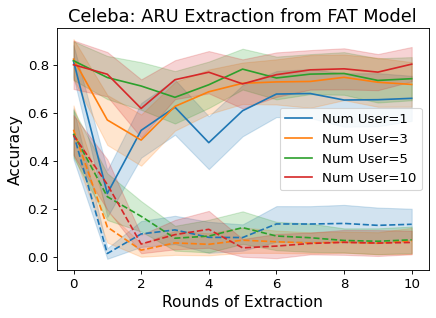

In [6]:

# Initialize a new figure
plt.figure(figsize=(6, 4), dpi=80)

# X-axis values: 0 to 30 in intervals of 5 (7 points)
x_values = np.arange(0, 11, 1)

# Define a colormap
colors = plt.get_cmap("tab10").colors

# Iterate over each num_user key
for i, num_user in enumerate(test_acc_gather.keys()):
    # Extract corresponding data for each num_user
    test_acc = test_acc_gather[num_user]
    adv_acc = adv_acc_gather[num_user]
    test_acc_std = test_acc_std_gather[num_user]
    adv_acc_std = adv_acc_std_gather[num_user]
    
    # Get the color for this line
    color = colors[i]
    
    # Plot test accuracy with standard deviation
    plt.plot(x_values, test_acc, label=f'Num User={num_user}', color=color)
    plt.fill_between(x_values, np.array(test_acc) - np.array(test_acc_std),
                     np.array(test_acc) + np.array(test_acc_std), color=color, alpha=0.2)
    
    # Plot adversarial accuracy with standard deviation (dotted line)
    plt.plot(x_values, adv_acc, linestyle='--', color=color)
    plt.fill_between(x_values, np.array(adv_acc) - np.array(adv_acc_std),
                     np.array(adv_acc) + np.array(adv_acc_std), color=color, alpha=0.2)

# Add title and labels with increased font size
plt.title('Celeba: ARU Extraction from FAT Model', fontsize=16)
plt.xlabel('Rounds of Extraction', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Combine legend to remove duplicates and label clarity with larger font
plt.legend(loc='best', fontsize=12)

# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show the plot
plt.show()